In [2]:
## Decision Tree Modeling in Python

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from matplotlib import pyplot as plt
np.random.seed(66)

churn = pd.read_csv('https://raw.githubusercontent.com/yhat/demo-churn-pred/master/model/churn.csv')
churn["Int'l Plan"] = churn["Int'l Plan"].map(dict(yes=1, no=0))
churn['VMail Plan'] = churn['VMail Plan'].replace({"yes": 1, "no": 0})
churn.select_dtypes('object').columns

Index(['State', 'Phone', 'Churn?'], dtype='object')

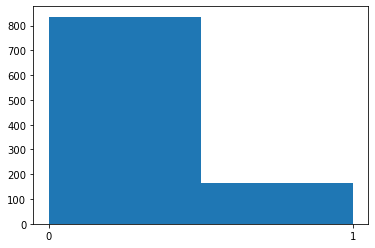

In [3]:
## Model Training/Testing

num_vars = churn.select_dtypes('number').columns
X = churn[num_vars]
y = churn['Churn?'].map({'True.': 1, 'False.': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.hist(y_pred, bins=2)
plt.xticks(range(0, 2))
plt.show()

In [5]:
## Performance Reporting

print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion.index = [['Real', 'Real'], ['Stay', 'Leave']]
df_confusion.columns = [['Predict'] * 2, ['Stay', 'Leave']]
df_confusion


Accuracy: 90.0%


Predict      
              Stay Leave
Real Stay      786    50
     Leave      50   114

In [6]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       836
           1       0.70      0.70      0.70       164

    accuracy                           0.90      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.90      0.90      0.90      1000



In [9]:
## Hyperparameters' Grid Search

param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 10, 20, 30],
              'max_depth': [4, 5, 6, 10, 15, 20],
              'min_samples_leaf': [ 1, 5, 10],
              'max_leaf_nodes': [2, 5, 10, 20]}
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 10, 15, 20],
                         'max_leaf_nodes': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20, 30]})


In [10]:
## Repeated Hold-Out Method

bstrap = ShuffleSplit(n_splits=10, test_size=0.3, random_state=16)
grid_bstrap = GridSearchCV(clf, param_grid, cv=bstrap)
grid_bstrap.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=16, test_size=0.3, train_size=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 10, 15, 20],
                         'max_leaf_nodes': [2, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20, 30]})

In [11]:
## Hyperparameters for Best Performinig Model

print(f"Accuracy: {round(grid_bstrap.best_score_*100, 2)}%")
for key, value in grid_bstrap.best_params_.items():
  print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 94.24%
Hyperparameter: criterion; Value: entropy
Hyperparameter: max_depth; Value: 10
Hyperparameter: max_leaf_nodes; Value: 20
Hyperparameter: min_samples_leaf; Value: 10
Hyperparameter: min_samples_split; Value: 2


In [12]:
## Leave One Out

loocv = LeaveOneOut()
lv_score = cross_val_score(clf, X, y, cv=loocv)
print(f"Leave One Out accuracy is {round(lv_score.mean(), 2)}")

Leave One Out accuracy is 0.92


AUC = 0.8884350565993698


C:\Users\XILUJ\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Sensitivity')

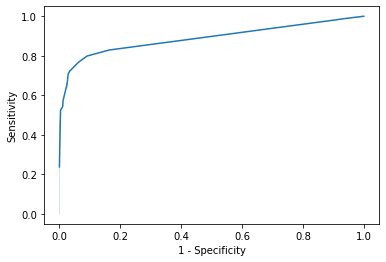

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = grid.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC = {auc}")
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

import seaborn as sns
sns.lineplot(fpr, tpr)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')